In [2]:
# Matrix Factorization
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt

# load data
with zipfile.ZipFile('archive.zip', 'r') as zipdata:
    print(zipdata.namelist())
    zipdata.extractall()
    zipdata.close()

raw_data = np.loadtxt('ml-100k/u.data', dtype='int', delimiter='\t')
# print(raw_data)
# print(raw_data.shape)

data = raw_data[:, :3]
data[:, :2] = data[:, :2] - 1
print(data)
print(data.shape, data.dtype)
print(f'users number: {len(np.unique(data[:,0]))} movies number: {len(np.unique(data[:,1]))}')

['ml-100k/README', 'ml-100k/allbut.pl', 'ml-100k/mku.sh', 'ml-100k/u.data', 'ml-100k/u.genre', 'ml-100k/u.info', 'ml-100k/u.item', 'ml-100k/u.occupation', 'ml-100k/u.user', 'ml-100k/u1.base', 'ml-100k/u1.test', 'ml-100k/u2.base', 'ml-100k/u2.test', 'ml-100k/u3.base', 'ml-100k/u3.test', 'ml-100k/u4.base', 'ml-100k/u4.test', 'ml-100k/u5.base', 'ml-100k/u5.test', 'ml-100k/ua.base', 'ml-100k/ua.test', 'ml-100k/ub.base', 'ml-100k/ub.test']
[[ 195  241    3]
 [ 185  301    3]
 [  21  376    1]
 ...
 [ 275 1089    1]
 [  12  224    2]
 [  11  202    3]]
(100000, 3) int32
users number: 943 movies number: 1682


In [7]:
# data preprocessing
np.random.seed(0)

# randomize and split data
ratio = 0.8
split_idx = int(len(data) * ratio)
# data = np.random.permutation(data) 
np.random.shuffle(data)  # two ways to randomize data
train_data = data[:split_idx, :]
test_data = data[split_idx:, :]

# calculate number of users and movies occurancy for L2 norm
user_unique = len(np.unique(data[:,0]))
movie_unique = len(np.unique(data[:,1]))
user_occurancy = np.bincount(train_data[:, 0], minlength=user_unique)
movie_occurancy = np.bincount(train_data[:, 1], minlength=movie_unique)
print(user_occurancy[:10])
print(movie_occurancy[:10])

# construct matrix data with extracting every attributes' data
user_train, user_test = train_data[:, 0], test_data[:, 0]
movie_train, movie_test = test_data[:, 1], test_data[:, 1]
y_train, y_test = train_data[:, 2], test_data[:, 2]

[223  53  45  19 140 171 325  46  19 147]
[360 111  70 167  73  21 321 186 240  73]


[0.48118852417052815, 0.25110474665825105, 0.1881917951331153, 0.15782321281958933, 0.1397657832376271, 0.12769472633738643, 0.11899188683359346, 0.11237987477908645, 0.10716125820755439, 0.10292211302522525, 0.09940037605230947, 0.09642140739449617, 0.09386392844638702, 0.0916408426393836, 0.08968784776203485, 0.08795636260776171, 0.08640896069338289, 0.08501632328769816, 0.08375514752098732, 0.0826066744433342, 0.08155563095618668, 0.0805894549364405, 0.07969771838279124, 0.07887169170630347, 0.07810401034770845, 0.07738841671140152, 0.07671955829315227, 0.07609282824992471, 0.075504238382921, 0.07495031712623716]
[4.060359444503421, 2.236156626169731, 1.4565168900921706, 1.040450340404437, 0.7908098018209565, 0.6293763559181638, 0.5191946411423051, 0.4407492277610012, 0.3829127469799436, 0.3389750095002218, 0.30471160280144666, 0.27736928030101954, 0.2551006334889785, 0.23663425892343776, 0.22107509920487067, 0.20777986773343574, 0.19627730655979106, 0.18621599402855774, 0.177329499

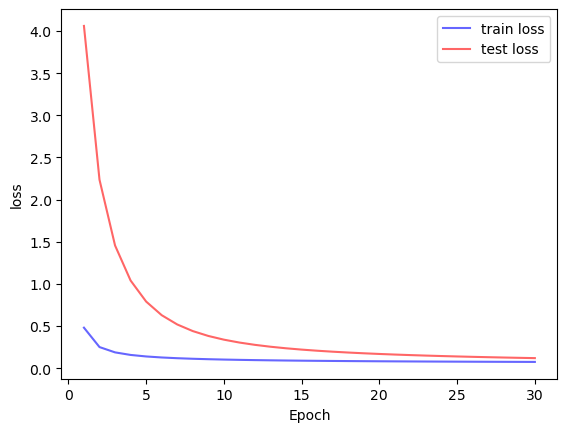

In [17]:
# Matrix Factorization
class MatrixFactorization(object):

    # initialize parameters for two matrix
    def __init__(self, num_user, num_movie, d) -> None:
        self.user_params = np.ones((num_user, d))    # shape: num_user x dimension
        self.movie_params = np.ones((num_movie, d))  # shape: num_movie x dimension

    def predict(self, user_id, movie_id):
        user_param = self.user_params[user_id]
        movie_param = self.movie_params[movie_id]
        prediction = np.sum(user_param * movie_param, axis=1) # equals to user_param.T @ movie_param
        return prediction
    
    def optimize(self, user_grads, movie_grads, learning_rate):
        self.user_params -= learning_rate * user_grads
        self.movie_params -= learning_rate * movie_grads
    
    def fit(self, user_train, movie_train, y_train, user_test, movie_test, y_test, epochs, batch_size, lr, lbd):
        train_losses = []
        test_losses = []
        batch_num = int(np.ceil(len(user_train) / batch_size))
        for epoch in range(epochs):
            train_rmse = 0
            for i in range(batch_num):
                # construct batches
                start = i * batch_size
                end = min(len(user_train), start + batch_size)
                user_batch = user_train[start:end]
                movie_batch = movie_train[start:end]
                y_batch = y_train[start:end]
                if(user_batch.shape[0] != movie_batch.shape[0]):
                    break
                # fit
                y_hat = self.predict(user_batch, movie_batch)
                # loss
                difference = y_batch - y_hat
                loss = np.mean(difference ** 2)
                train_rmse += loss
                # optimize
                P = self.user_params
                Q = self.movie_params
                P_grad = np.zeros_like(P)
                Q_grad = np.zeros_like(Q)
                for user, movie, diff in zip(user_batch, movie_batch, difference):
                    P_grad[user] = P_grad[user] - diff * Q[movie] + lbd * P[user]
                    Q_grad[movie] = Q_grad[movie] - diff * P[user] + lbd * Q[movie]
                self.optimize(P_grad / len(user_batch), Q_grad / len(movie_batch), lr)
            # evaluate train and test rmse
            train_rmse = np.sqrt(train_rmse / len(user_train))
            train_losses.append(train_rmse)

            y_pred = self.predict(user_test, movie_test)
            test_rmse = np.sqrt(np.mean(y_test - y_pred) ** 2)
            test_losses.append(test_rmse)
        return train_losses, test_losses

# hyper paramters
feature_dimension = 16
learning_rate = 0.1
lbd = 1e-4
n_epoch = 30
batch_size = 64

MF = MatrixFactorization(user_unique, movie_unique, feature_dimension)
train_losses, test_losses = MF.fit(user_train, movie_train, y_train, 
                                   user_test, movie_test, y_test, 
                                   n_epoch, batch_size, learning_rate, lbd)
print(train_losses)
print(test_losses)

# visualize loss curve
plt.figure()
x = np.arange(n_epoch) + 1
plt.plot(x, train_losses, 
         color='blue', 
         label='train loss', 
         alpha=0.6)
plt.plot(x, test_losses, 
         color='red', 
         label='test loss', 
         alpha=0.6)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()